In [187]:
#Load libraries
import os
#I Have problems with packages try running without this command 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import torch
import glob
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import sys
import platform
import time
# from google.colab import drive #used to access files
# drive.mount('/content/gdrive')

In [188]:
#checking for device
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if torch.backends.mps.is_built() \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-13.2-arm64-arm-64bit
PyTorch Version: 2.1.0.dev20230617

Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]
Pandas 2.0.2
Scikit-Learn 1.2.2
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


In [189]:
print(device)

mps


In [190]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)), #recommended size with 3x3 filters bigger images need larger filters
    transforms.RandomHorizontalFlip(), #chance of image being flipped is 0.5 to add variety to data set
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors (Pytorch uses tensor instead of numoy to manipulate images)
    transforms.Normalize([0.5,0.5,0.5], 
                         [0.5,0.5,0.5]) # 0-1 to [-1,1] , formula (x-mean)/std
])

In [191]:
#Dataloader

#Path for training and testing directory
train_path='/Users/hadi/Desktop/Concordia/Comp 6721/AIproject/fruits/training/'
test_path='/Users/hadi/Desktop/Concordia/Comp 6721/AIproject/fruits/testing/'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
#by deault it was 64 but ta said use 32 (Personally I think 64 is better because we have lots of images)

test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [192]:
#Returning classes
root=pathlib.Path(train_path)
classes = []
for j in root.iterdir():
    if j.name.split('/')[-1] != ".DS_Store":
        classes.append(j.name.split('/')[-1])

In [193]:
print(classes)

['Banana_Training', 'Kiwi_Training', 'Mango_Training', 'Orange_Training', 'Plum_Training', 'Apple_Training']


In [194]:
#Building CNN netwrok



class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()

        #Output size after convolution filter
        #((w-f+2P)/s) +1 w: width (32) - f: kernel size (filter) - p:padding - s:stride

        #Input shape= (256,3,150,150) 32: batch size - 3: rgb channels - 32x32: image size

        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)

        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)


        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)



        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)


        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)



        #Feed forwad function
        #as we go deeper in the netwrok the number of channel increase to capture more complex and detailed features
        

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)

        output=self.pool(output)

        output=self.conv2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)


        #Above output will be in matrix form, with shape (256,32,75,75)

        output=output.view(-1,32*75*75)


        output=self.fc(output)

        return output

In [195]:
model=ConvNet(num_classes=6).to(device)

In [196]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001) #0.0005 #0.0001
loss_function=nn.CrossEntropyLoss()

In [197]:
num_epochs=10

In [198]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.png'))
test_count=len(glob.glob(test_path+'/**/*.png'))
print(train_count,test_count)

18341 4583


In [199]:
#Model training and saving best model

best_accuracy=0.0
metrics = np.empty((0, 3))  # Initialize an empty matrix

for epoch in range(num_epochs):
    
    start_time = time.time()  # Start time of the epoch

    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0

    for i, (images,labels) in enumerate(train_loader):
        if torch.backends.mps.is_built():
            images=Variable(images.to(device))
            labels=Variable(labels.to(device))

        optimizer.zero_grad()

        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()


        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))

    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count


    # Evaluation on testing dataset
    model.eval()

    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.backends.mps.is_built():
            images=Variable(images.to(device))
            labels=Variable(labels.to(device))

        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))

    test_accuracy=test_accuracy/test_count

    metric_per_epoch = np.array([train_loss,train_accuracy,test_accuracy])  #Array that holds value of metrics per epoch
    metrics = np.vstack((metrics, metric_per_epoch))
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy
        
    # Calculate elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(' Elapsed Time: ' + str(elapsed_time) + ' seconds')
    
    #end of an epoch
        

Epoch: 0 Train Loss: tensor(2.3664) Train Accuracy: 0.8835396107082493 Test Accuracy: 0.9194850534584333
 Elapsed Time: 96.76247930526733 seconds
Epoch: 1 Train Loss: tensor(0.3270) Train Accuracy: 0.9669592715773404 Test Accuracy: 0.9685795330569495
 Elapsed Time: 95.0647189617157 seconds
Epoch: 2 Train Loss: tensor(0.2822) Train Accuracy: 0.9759555095142032 Test Accuracy: 0.9685795330569495
 Elapsed Time: 93.51706027984619 seconds
Epoch: 3 Train Loss: tensor(0.0998) Train Accuracy: 0.9892045144757646 Test Accuracy: 0.9716343006764129
 Elapsed Time: 117.82537317276001 seconds
Epoch: 4 Train Loss: tensor(0.1517) Train Accuracy: 0.9866964723842757 Test Accuracy: 0.9242854025747327
 Elapsed Time: 675.3284590244293 seconds
Epoch: 5 Train Loss: tensor(0.2430) Train Accuracy: 0.9848972247969031 Test Accuracy: 0.9703251145537858
 Elapsed Time: 94.36292886734009 seconds
Epoch: 6 Train Loss: tensor(0.1469) Train Accuracy: 0.9891499918216019 Test Accuracy: 0.9613790093825005
 Elapsed Time: 1038

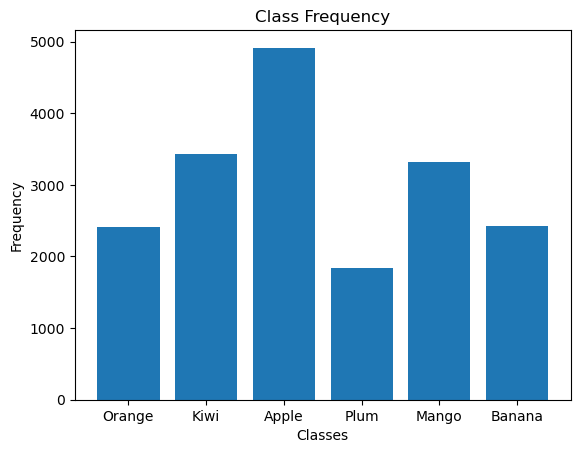

In [200]:
import matplotlib.pyplot as plt

train_count_orange=len(glob.glob(train_path+'/Orange_Training/*.png'))
train_count_kiwi=len(glob.glob(train_path+'/Kiwi_Training/*.png'))
train_count_apple=len(glob.glob(train_path+'/Apple_Training/*.png'))
train_count_plum=len(glob.glob(train_path+'/Plum_Training/*.png'))
train_count_mango=len(glob.glob(train_path+'/Mango_Training/*.png'))
train_count_banana=len(glob.glob(train_path+'/Banana_Training/*.png'))

# Count the frequency of each label
label_counts = {"Orange":train_count_orange,"Kiwi":train_count_kiwi,"Apple":train_count_apple,"Plum":train_count_plum,"Mango":train_count_mango,"Banana":train_count_banana}

# Extract the labels and frequencies
x = list(label_counts.keys())
y = list(label_counts.values())

# Plotting the graph
plt.bar(x, y)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Class Frequency')
plt.show()


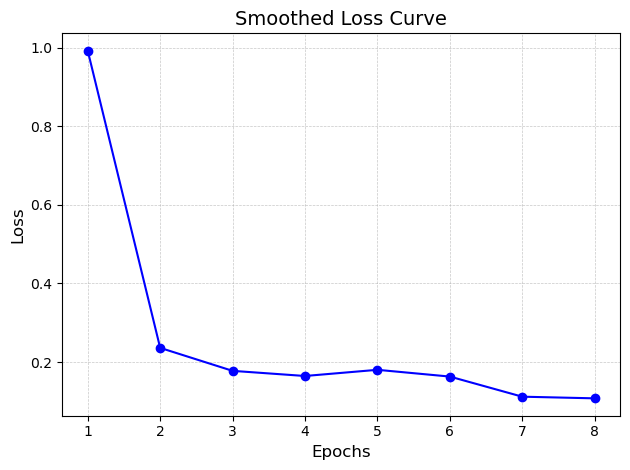

In [201]:
#Plot for the loss curve

loss_values = []

for m in metrics:
  loss_values.append(m[0])

# Apply moving average to smooth out the loss values
window_size = 3  # Adjust the window size as desired
loss_values_smooth = np.convolve(loss_values, np.ones(window_size)/window_size, mode='valid')

# Generate x-axis values for epochs
epochs = range(1, len(loss_values_smooth) + 1)

# Plotting the smoothed loss curve
plt.plot(epochs, loss_values_smooth, 'b-o')

# Customize plot appearance
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Smoothed Loss Curve', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

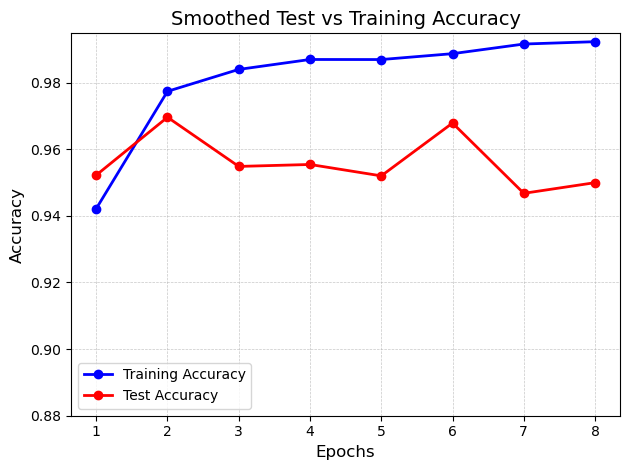

In [202]:
#plot for the test vs training accuracy to check overfiiting

training_accuracy = []
test_accuracy = []

for m in metrics:
  training_accuracy.append(m[1])
  test_accuracy.append(m[2])

# Apply moving average to smooth out the accuracy values
window_size = 3  # Adjust the window size as desired
training_accuracy_smooth = np.convolve(training_accuracy, np.ones(window_size)/window_size, mode='valid')
test_accuracy_smooth = np.convolve(test_accuracy, np.ones(window_size)/window_size, mode='valid')

# Generate x-axis values for epochs
epochs = range(1, len(training_accuracy_smooth) + 1)

# Plotting the smoothed test vs training accuracy
plt.plot(epochs, training_accuracy_smooth, 'b-o', label='Training Accuracy', linewidth=2, markersize=6)
plt.plot(epochs, test_accuracy_smooth, 'r-o', label='Test Accuracy', linewidth=2, markersize=6)

# Customize plot appearance
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Smoothed Test vs Training Accuracy', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(np.arange(0.88, 1, 0.02),fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()